# Time series forecasting 

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (14, 10)
mpl.rcParams['axes.grid'] = False

## Data loading

Load dataset and rename columns to understandable formats

In [2]:
DATA_PATH = "../data/extract.txt"

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPD": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
}

columns = list(cols_map.values())

df = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
df.rename(columns=cols_map, inplace=True)

df.head()

,crossTime,lane,direction,speed,nAxles,weight,type
0,20000104T000557,1,1,101,2,17930,11
1,20000104T002824,1,1,83,2,5230,11
2,20000104T003457,1,1,84,2,8310,11
3,20000104T011414,1,1,89,2,7550,11
4,20000104T022526,1,1,104,3,20930,12


Parse crossing time as datetime

In [3]:
df.crossTime = pd.to_datetime(df.crossTime, format="%Y%m%dT%H%M%S")
df.head()

,crossTime,lane,direction,speed,nAxles,weight,type
0,2000-01-04 00:05:57,1,1,101,2,17930,11
1,2000-01-04 00:28:24,1,1,83,2,5230,11
2,2000-01-04 00:34:57,1,1,84,2,8310,11
3,2000-01-04 01:14:14,1,1,89,2,7550,11
4,2000-01-04 02:25:26,1,1,104,3,20930,12


Check to see if there is any invalid data

In [4]:
df.isna().sum()

crossTime    0
lane         0
direction    0
speed        0
nAxles       0
weight       0
type         0
dtype: int64

Convert feature "type" to categorical type

In [5]:
df['type'] = df.type.astype('category')

In [6]:
df

,crossTime,lane,direction,speed,nAxles,weight,type
0,2000-01-04 00:05:57,1,1,101,2,17930,11
1,2000-01-04 00:28:24,1,1,83,2,5230,11
2,2000-01-04 00:34:57,1,1,84,2,8310,11
3,2000-01-04 01:14:14,1,1,89,2,7550,11
4,2000-01-04 02:25:26,1,1,104,3,20930,12
...,...,...,...,...,...,...,...
9994,2000-01-13 05:09:23,1,1,92,4,9960,112
9995,2000-01-13 05:09:57,1,1,91,2,11060,11
9996,2000-01-13 05:14:12,1,1,88,5,14810,122
9997,2000-01-13 05:18:25,1,1,86,3,12340,12


## Initial data explortation

Compute summary statistics

In [7]:
df.describe()

,lane,direction,speed,nAxles,weight
count,9999.0,9999.0,9999.000000,9999.000000,9999.000000
mean,1.0,1.0,88.238024,3.225723,12335.469547
std,0.0,0.0,7.028601,1.111846,6135.098224
min,1.0,1.0,21.000000,2.000000,3500.000000
25%,1.0,1.0,85.000000,2.000000,7630.000000
50%,1.0,1.0,88.000000,3.000000,11440.000000
75%,1.0,1.0,89.000000,4.000000,15630.000000
max,1.0,1.0,184.000000,8.000000,52440.000000


Find the date range of our data

In [8]:
mn, mx = df.crossTime.min(), df.crossTime.max()
print(f"Our data ranges from {mn} to {mx}, ranging a period of {mx - mn}")

Our data ranges from 2000-01-04 00:05:57 to 2000-01-13 05:21:11, ranging a period of 9 days 05:15:14


Explore the other columns of the data

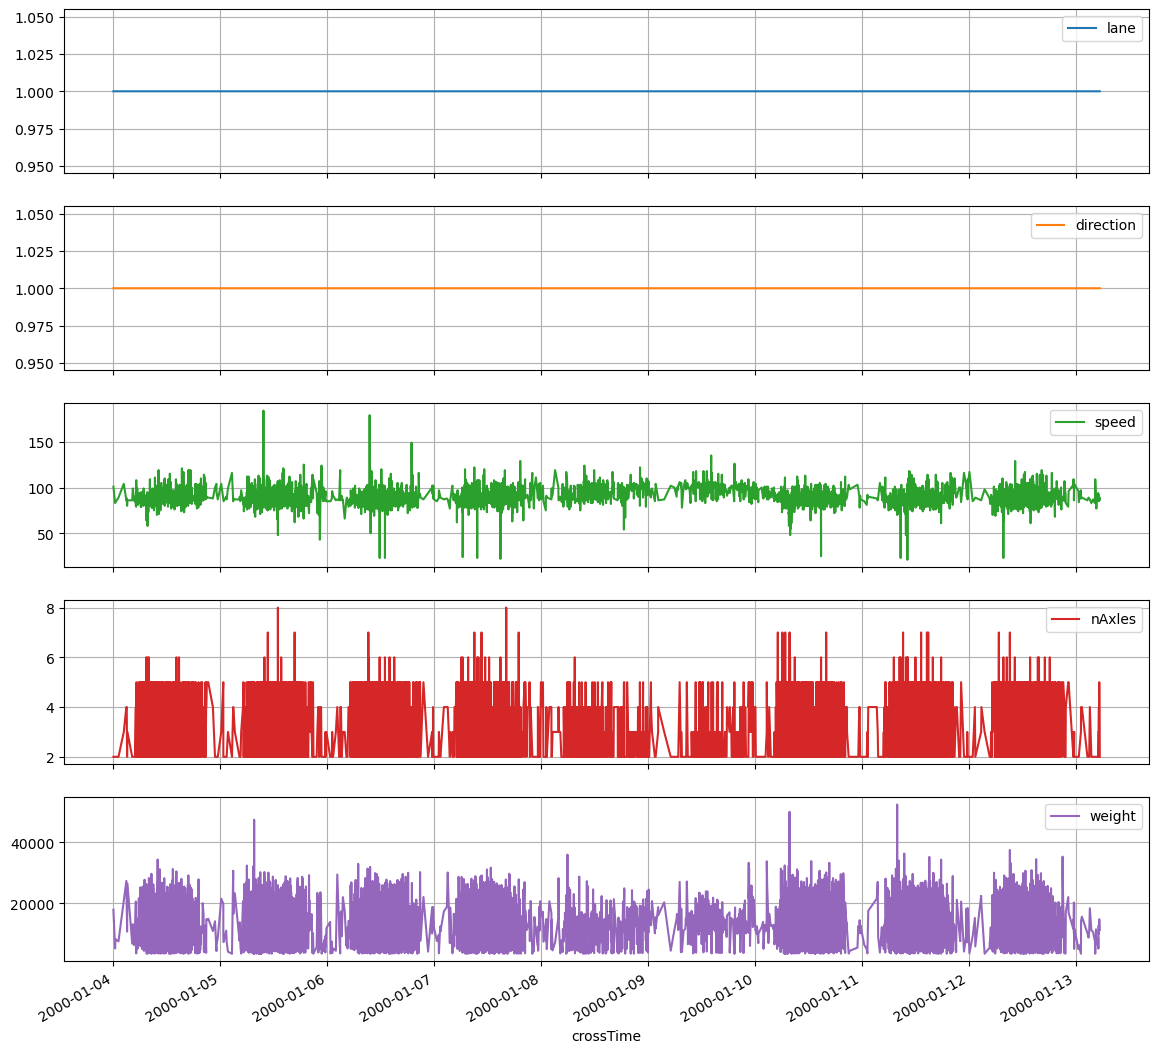

In [9]:
plot_cols = [col for col in columns if col != 'crossTime']

plot_features = df[plot_cols]
plot_features.index = df.crossTime

plot_features.plot(subplots=True, figsize=(14, 14), grid=True)
plt.show()

Downsample the series into 1 hour bins and compute the mean of the values of the timestamps falling into a bin.

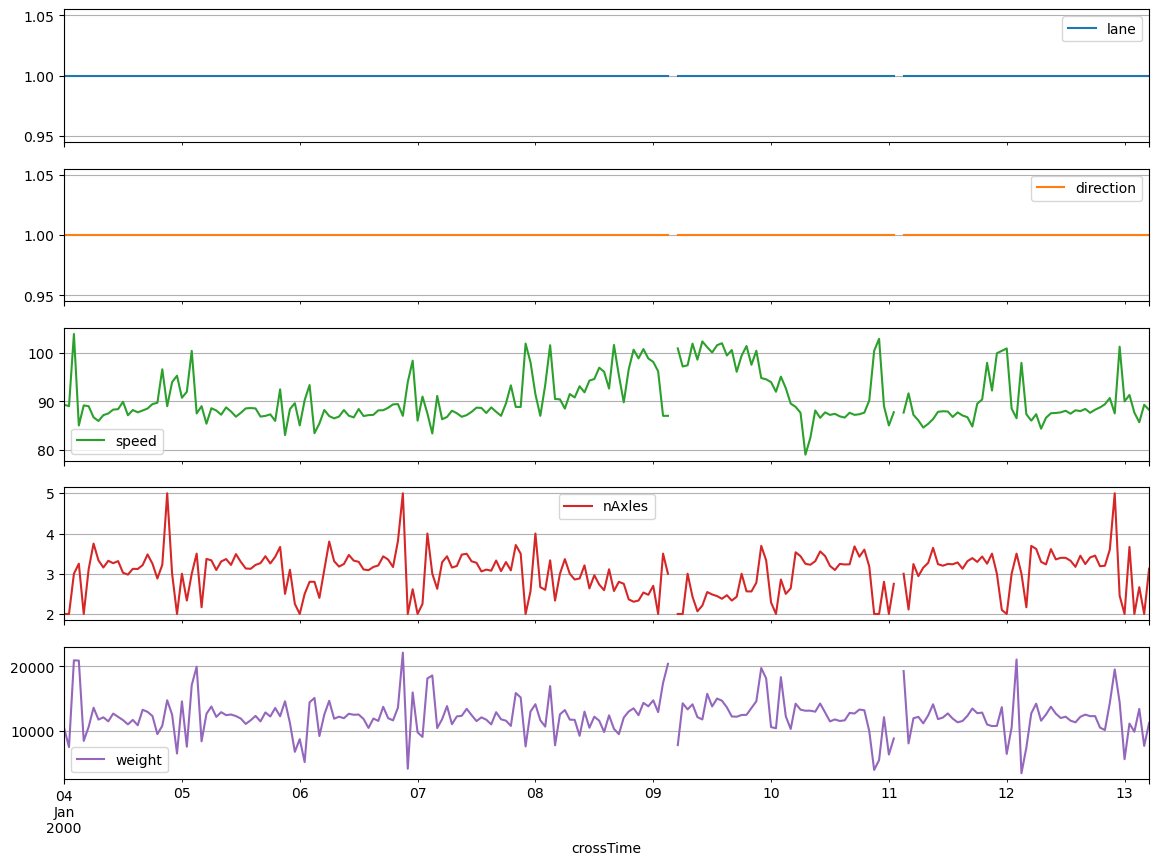

In [10]:
plot_features.resample('1h').mean().plot(subplots=True, grid=True)
plt.show()

Convert categorical variable into dummy variables + plot

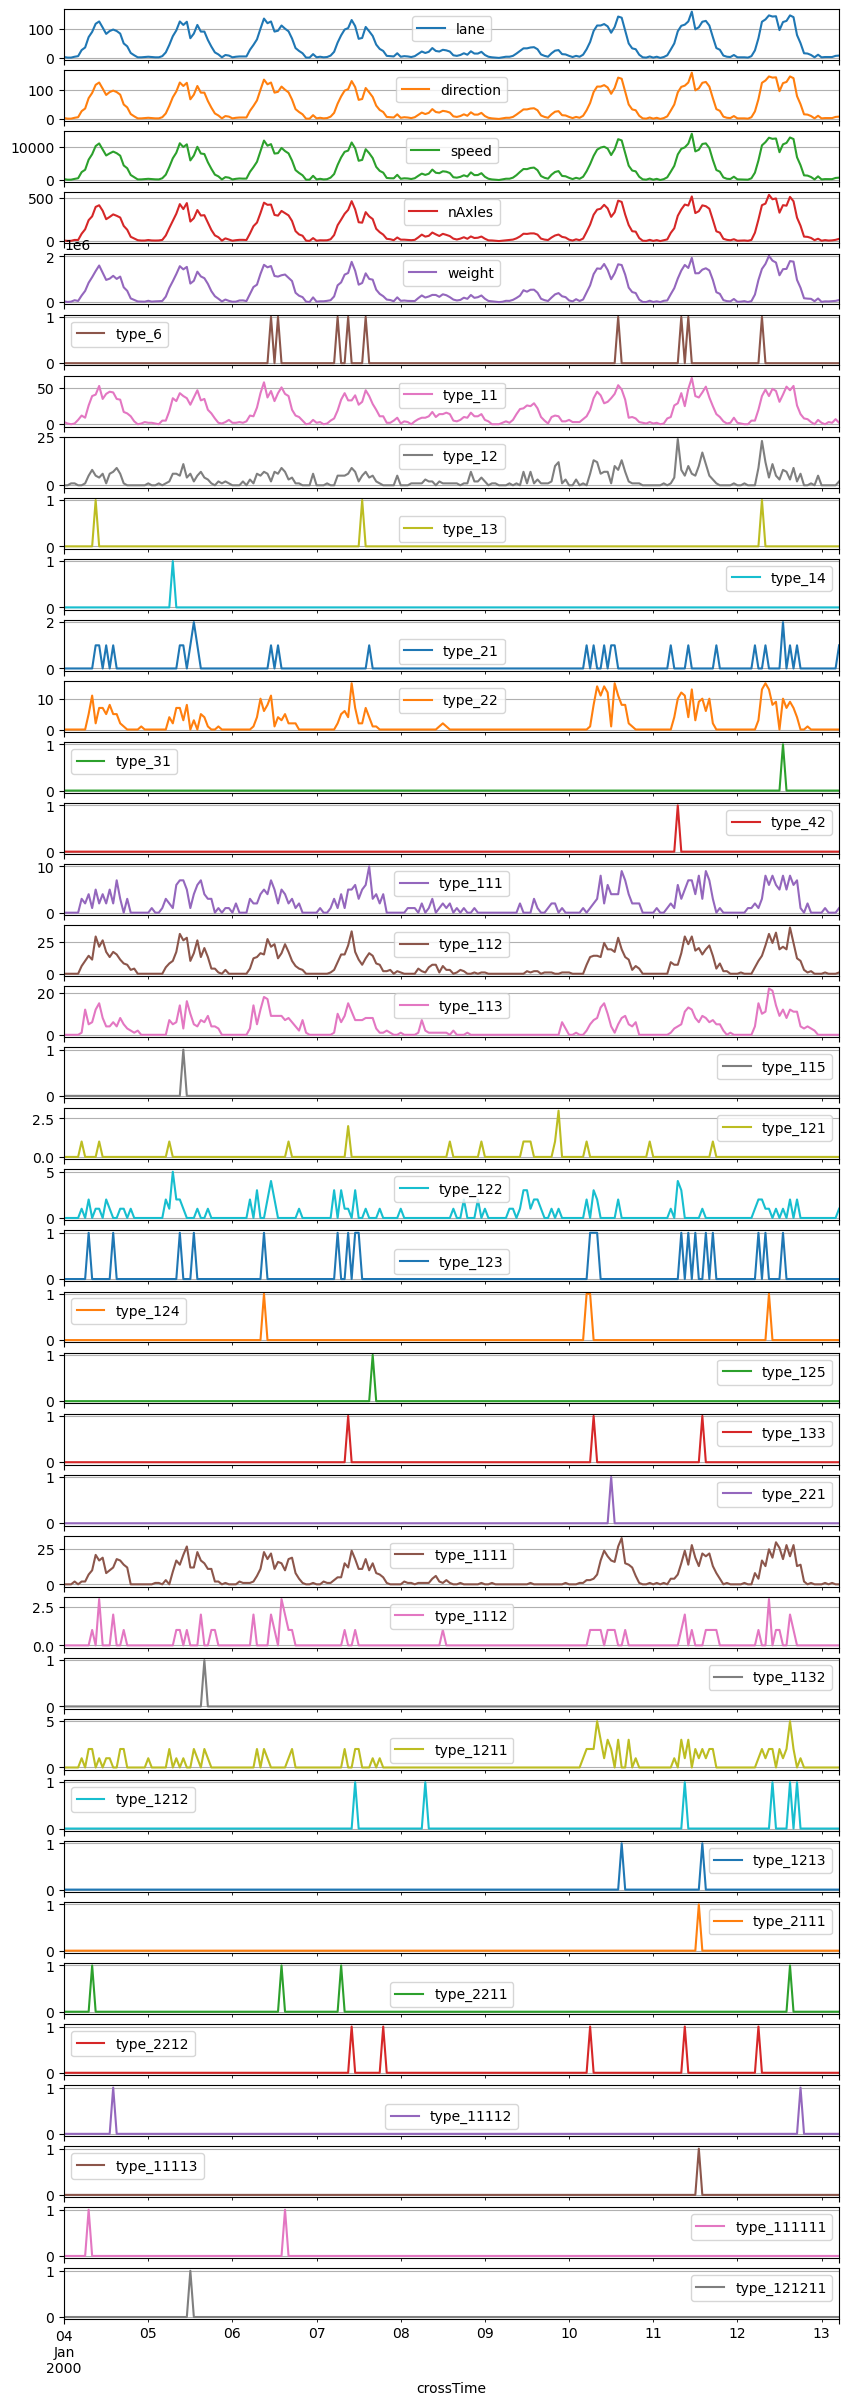

In [11]:
pd.get_dummies(plot_features).resample('1h').sum().plot(subplots=True, figsize=(10, 30), grid=True)
plt.show()

#### Time data exploration

In [12]:
time_column = df['crossTime']
n_rows = len(time_column.index)

time_steps = time_column.diff().astype('timedelta64[s]')[1:]
min_dt, max_dt = time_steps.min(), time_steps.max()
print(f'Minimum dt: {min_dt} \nMaximum dt: {max_dt}')

Minimum dt: 0.0 
Maximum dt: 6921.0


In [13]:
time_steps.plot(kind='hist', bins=100, log=True, figsize=(15,4)).set_xlabel("Time step [s]")

Text(0.5, 0, 'Time step [s]')

In [14]:
time_steps.describe()

count    9998.000000
mean       79.667333
std       257.433715
min         0.000000
25%        10.000000
50%        29.000000
75%        65.000000
max      6921.000000
Name: crossTime, dtype: float64

Power law? Poisson? Investigate this.

## On new dataset

In [216]:
DATA_PATH = "../data/405.txt"

cols_map = {
    "DTS": "crossTime",
    "LANE": "lane",
    "DIR": "direction",
    "SPEED": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
    "Year": "year",
    "Month": "month",
    "Day" : "day",
    "Hour" : "hour",
    "Minute" : "minute",
}

columns = list(cols_map.values())

new_df = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
new_df.rename(columns=cols_map, inplace=True)
new_df['crossTime'] = pd.to_datetime(new_df['crossTime'])

new_df.head()

,crossTime,lane,direction,speed,nAxles,weight,type,year,month,day,hour,minute
0,2011-04-01 00:41:31.400,2,1,106,2,15980,11,2011,4,1,0,41
1,2011-04-01 00:42:10.500,2,1,116,2,3630,11,2011,4,1,0,42
2,2011-04-01 00:47:15.700,2,1,84,4,18480,1111,2011,4,1,0,47
3,2011-04-01 01:23:37.200,2,1,88,2,11050,11,2011,4,1,1,23
4,2011-04-01 01:33:23.400,2,1,89,5,30330,113,2011,4,1,1,33


In [161]:
#Check if there is any na
new_df.isna().sum()

crossTime    0
lane         0
direction    0
speed        0
nAxles       0
weight       0
type         0
year         0
month        0
day          0
hour         0
minute       0
dtype: int64

In [217]:
#convert feature type into category
new_df['type'] = new_df.type.astype('category')

In [218]:
mn, mx = new_df.crossTime.min(), new_df.crossTime.max()
print(f"Our data ranges from {mn} to {mx}, ranging a period of {mx - mn}")

Our data ranges from 2011-04-01 00:41:31.400000 to 2021-03-28 23:29:14.400000, ranging a period of 3649 days 22:47:43


Compute summary statistics

In [164]:
new_df.describe()

,lane,direction,speed,nAxles,weight,year,month,day,hour,minute
count,4.841075e+06,4841075.0,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06,4.841075e+06
mean,1.635797e+00,1.0,8.586481e+01,3.491157e+00,1.660369e+04,2.016032e+03,6.489607e+00,1.576537e+01,1.183112e+01,2.954497e+01
std,4.812061e-01,0.0,9.172992e+00,1.232331e+00,1.084427e+04,2.988873e+00,3.348895e+00,8.665441e+00,4.092801e+00,1.731409e+01
min,1.000000e+00,1.0,0.000000e+00,2.000000e+00,3.500000e+03,2.011000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.0,8.300000e+01,2.000000e+00,7.720000e+03,2.013000e+03,4.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01
50%,2.000000e+00,1.0,8.700000e+01,4.000000e+00,1.513000e+04,2.016000e+03,6.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01
75%,2.000000e+00,1.0,8.900000e+01,4.000000e+00,2.138000e+04,2.019000e+03,9.000000e+00,2.300000e+01,1.500000e+01,4.500000e+01
max,2.000000e+00,1.0,2.550000e+02,9.000000e+00,9.994000e+04,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01


From the summary statistics :
- The standard deviation of the direction is 0, meaning we can drop this column.
- The standard deviation of the lane is not exactly 0, meaning we have multiple lanes
- The minimum measured weight is 3500kg.
- We have monster trucks with 9 axles of type 111111111 

In [219]:
new_df.drop('direction', axis=1, inplace=True)
new_df['lane'] = new_df.lane.astype('category')
new_df['lane'].unique()

[2, 1]
Categories (2, int64): [1, 2]

In [197]:
lane_1 = new_df[new_df['lane'].isin([1])]
lane_2 = new_df[new_df['lane'].isin([2])]
nType, nType_1, nType_2 = new_df.type.nunique(), lane_1.type.nunique(), lane_2.type.nunique()
print(f"There are {nType} types in total, {nType_1} on lane 1 and {nType_2} on lane 2")

There are 272 types in total, 193 on lane 1 and 255 on lane 2


In [134]:
#Choosing a specific period of time from the entire dataset.
def choose_date(df, year=None, month=None, day=None, hour=None):
    if year != None:
        df = df[(df.year == year)]
    if month != None:
        df = df[(df.month == month)]
    if day != None:
        df = df[(df.day == day)]
    if hour != None:
        df = df[(df.hour == hour)]
    return df

In [175]:
lane_1_2018_4 = choose_date(lane_1, year = 2018, month = 4)
lane_2_2018_4 = choose_date(lane_2, year = 2018, month = 4)
lane_1_2018_4.index = lane_1_2018_4['crossTime']
lane_2_2018_4.index = lane_2_2018_4['crossTime']

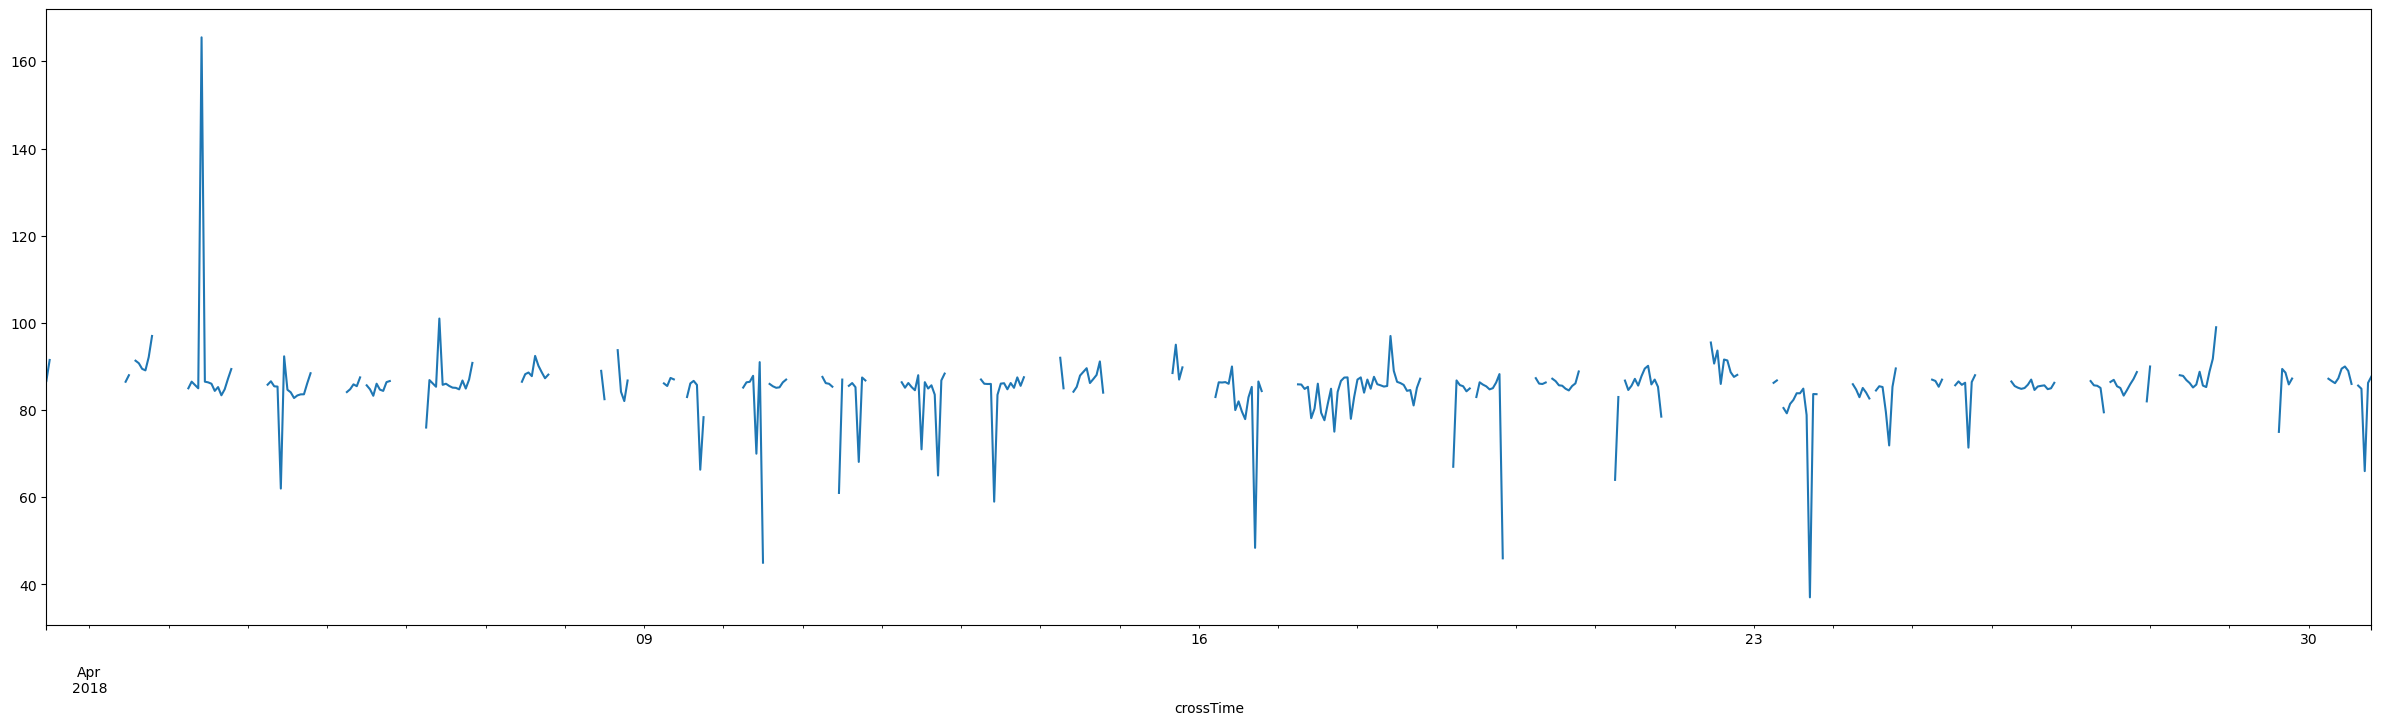

In [200]:
plt.figure(figsize=(30,8))
lane_1_2018_4['speed'].resample('1h').mean().plot()
plt.show()

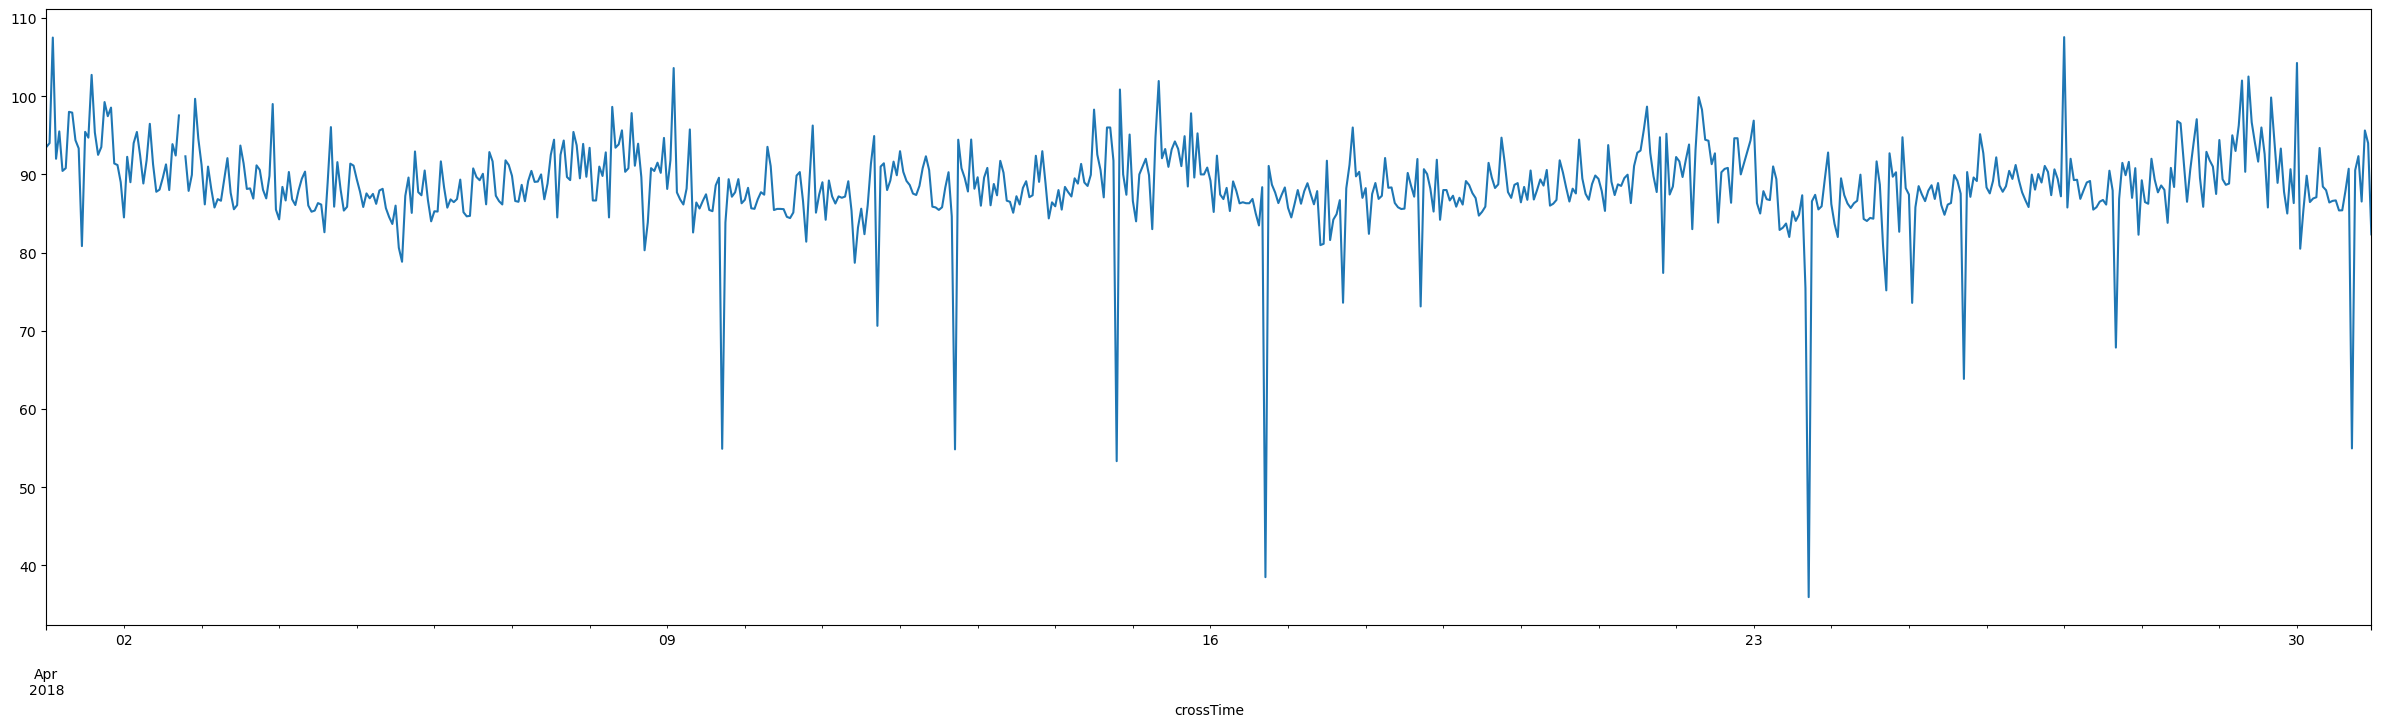

In [201]:
plt.figure(figsize=(30,8))
lane_2_2018_4['speed'].resample('1h').mean().plot()
plt.show()

Usually one drives on the right lane and overtake on the left lane. Here the lane_1 is the left lane and lane_2 is the right one as there are less cars on the lane 1

### Explore speed and weight throughout the year, month, week and day

In [254]:
new_df_2018 = choose_date(new_df, year = 2018)
new_df_2018_4 = choose_date(new_df_2018, month = 4)
new_df_2018_4_10 = choose_date(new_df_2018_4, day = 10)
new_df_2018_4_week = new_df_2018_4.loc[(new_df_2018_4['day'] >= 9) & (new_df_2018_4['day'] <= 15)]

In [257]:
#plot_features = new_df_2018_4.loc[:, ['speed', 'nAxles', 'weight']]

#plot_features.index = new_df_2018_4['crossTime']
#plot_features.resample('1h').mean().plot(subplots=True, grid=True)
#plt.show()

We can see that the number of axles and the weight are highly correlated, so we decide to drop the nAxles feature.

In [228]:
new_df.drop('nAxles', axis=1, inplace=True)
new_df_2018_4.drop('nAxles', axis=1, inplace=True)

yaaaaaay colors

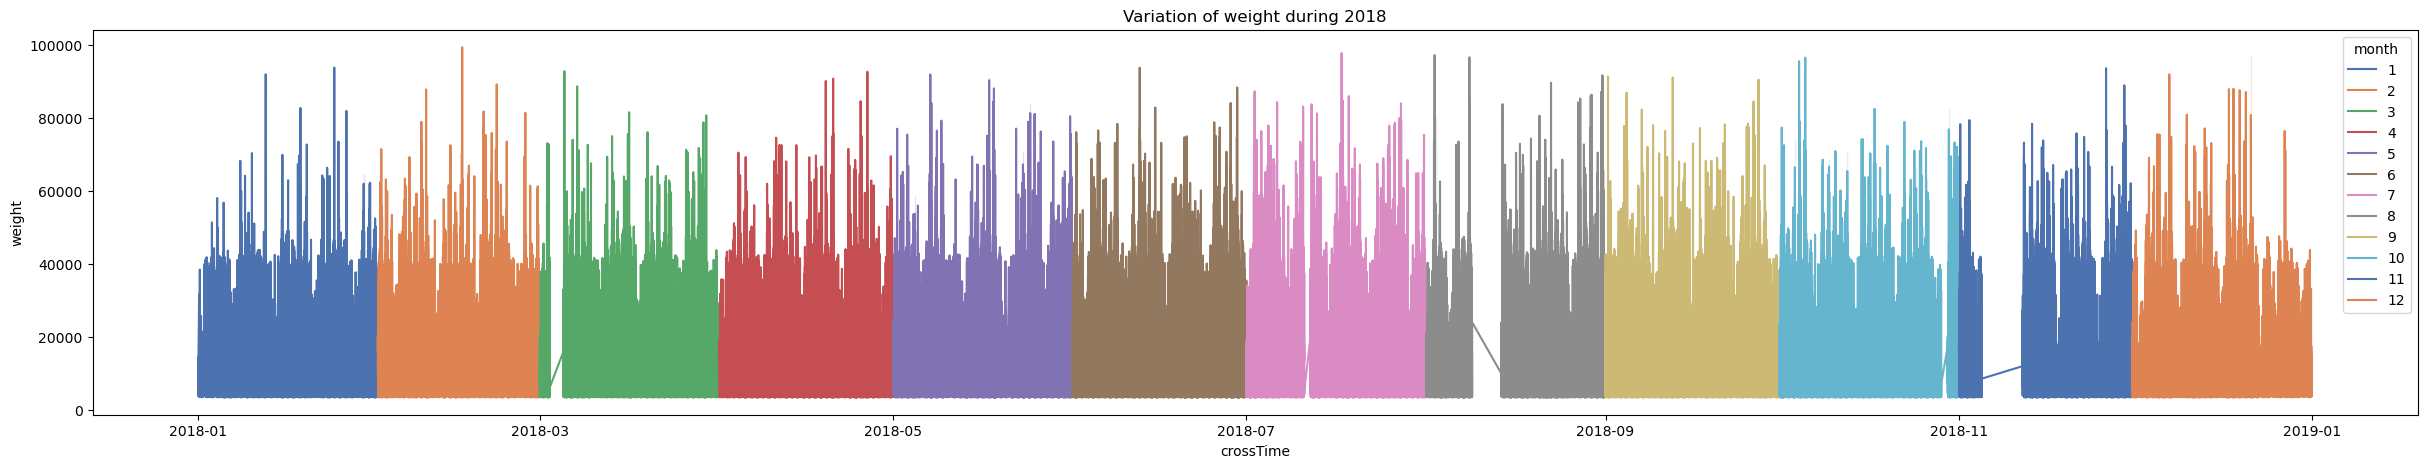

In [258]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 2018')
sns.lineplot(x = new_df_2018.crossTime, y= new_df_2018.weight, hue=new_df_2018.month, palette="deep");
plt.show()

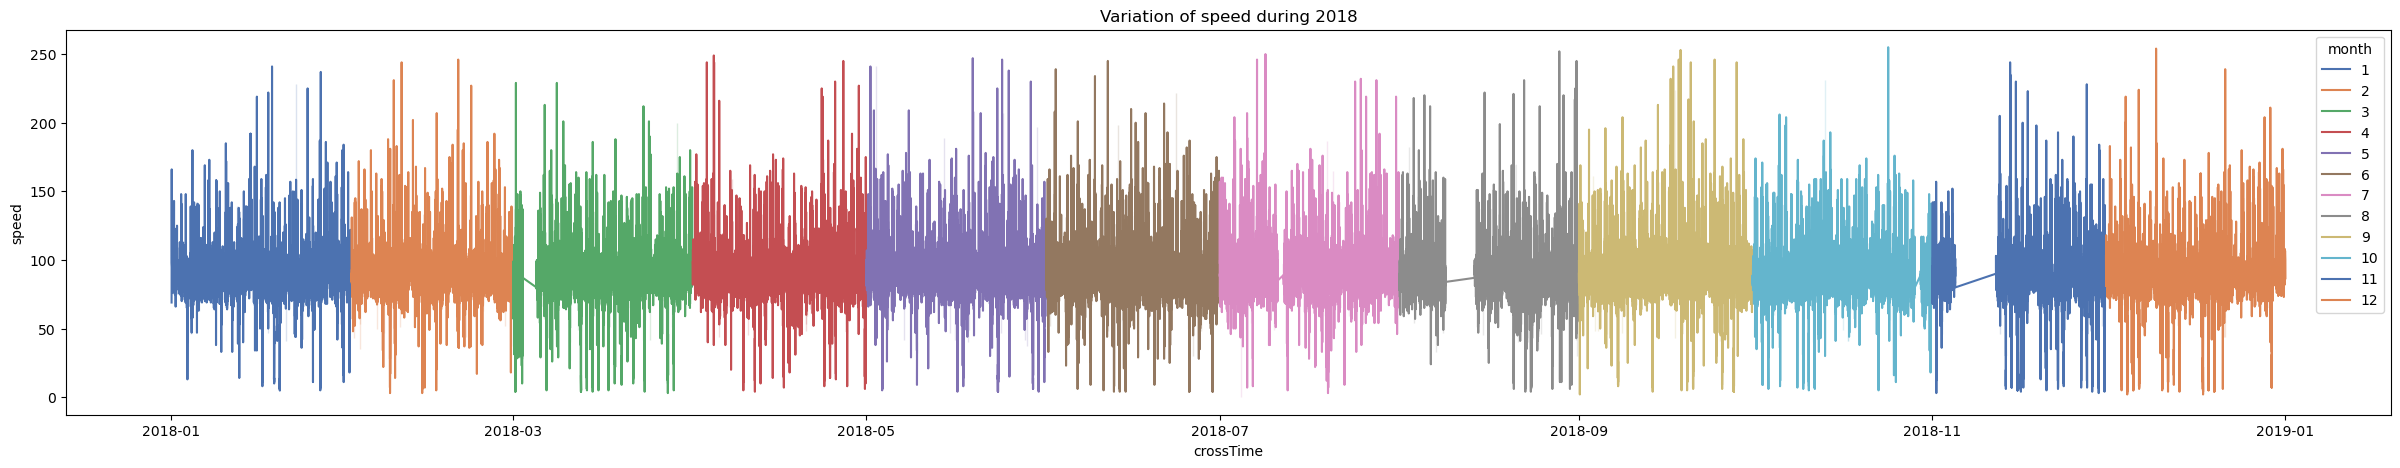

In [260]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 2018')
sns.lineplot(x = new_df_2018.crossTime, y= new_df_2018.speed, hue=new_df_2018.month, palette="deep");
plt.show()

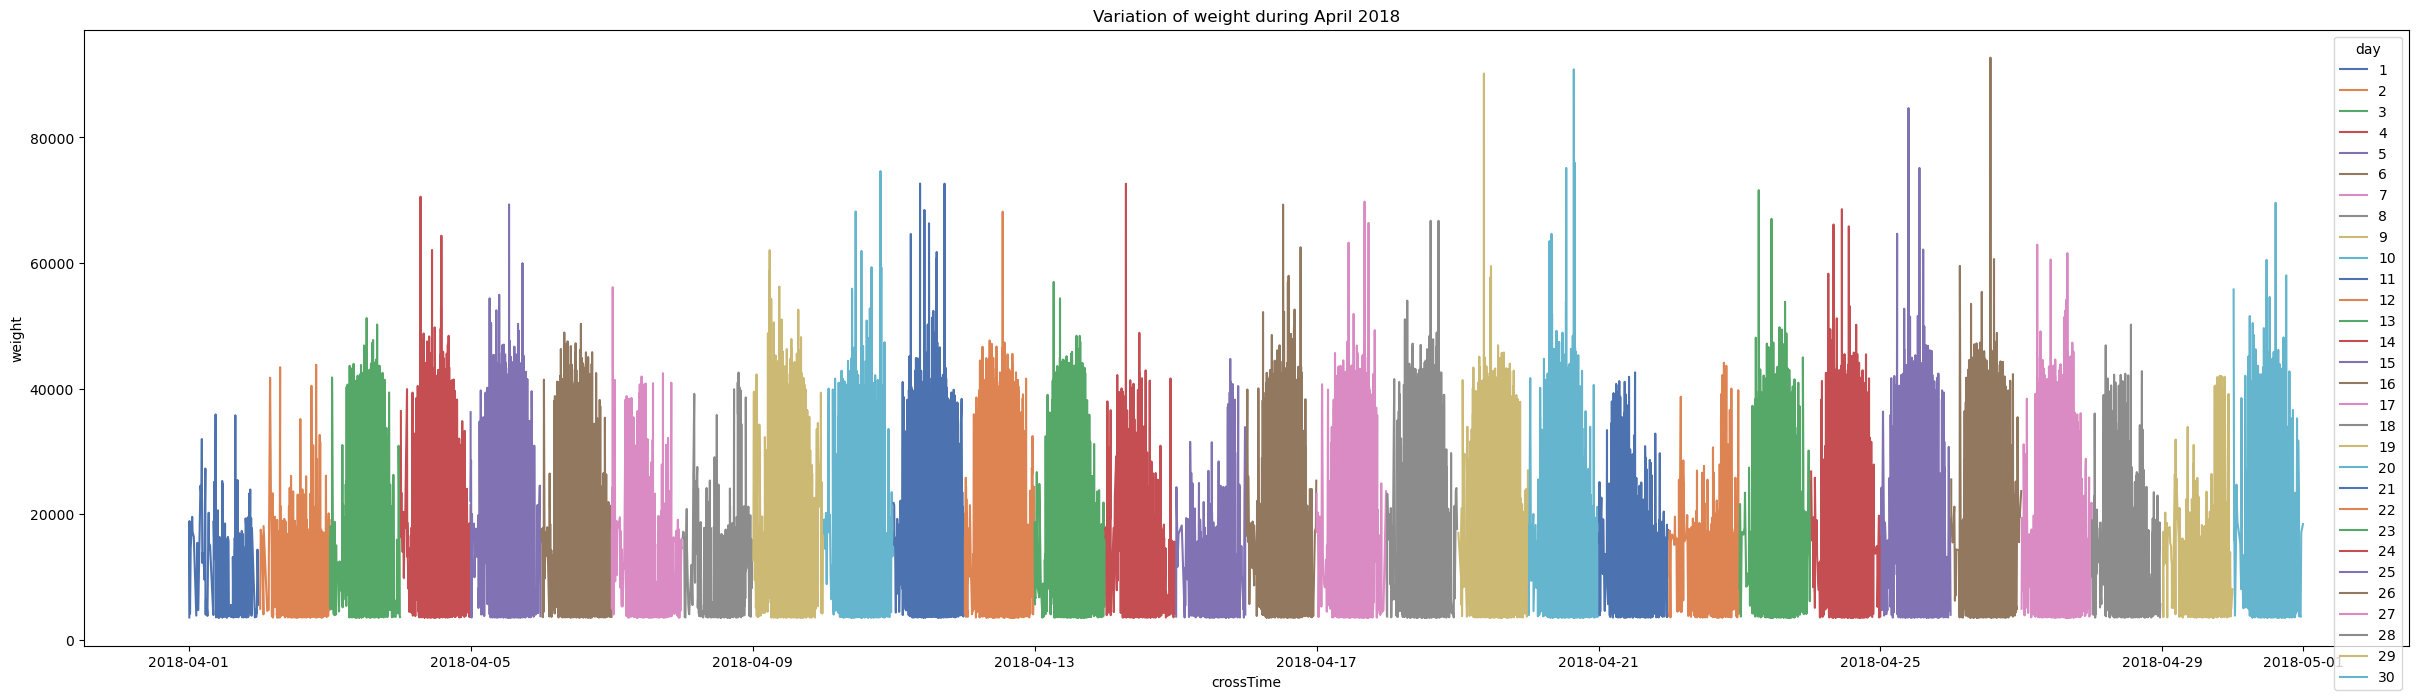

In [253]:
plt.figure(figsize=(30,8))
plt.title('Variation of weight during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.weight, hue=new_df_2018_4.day, palette="deep");
plt.show()

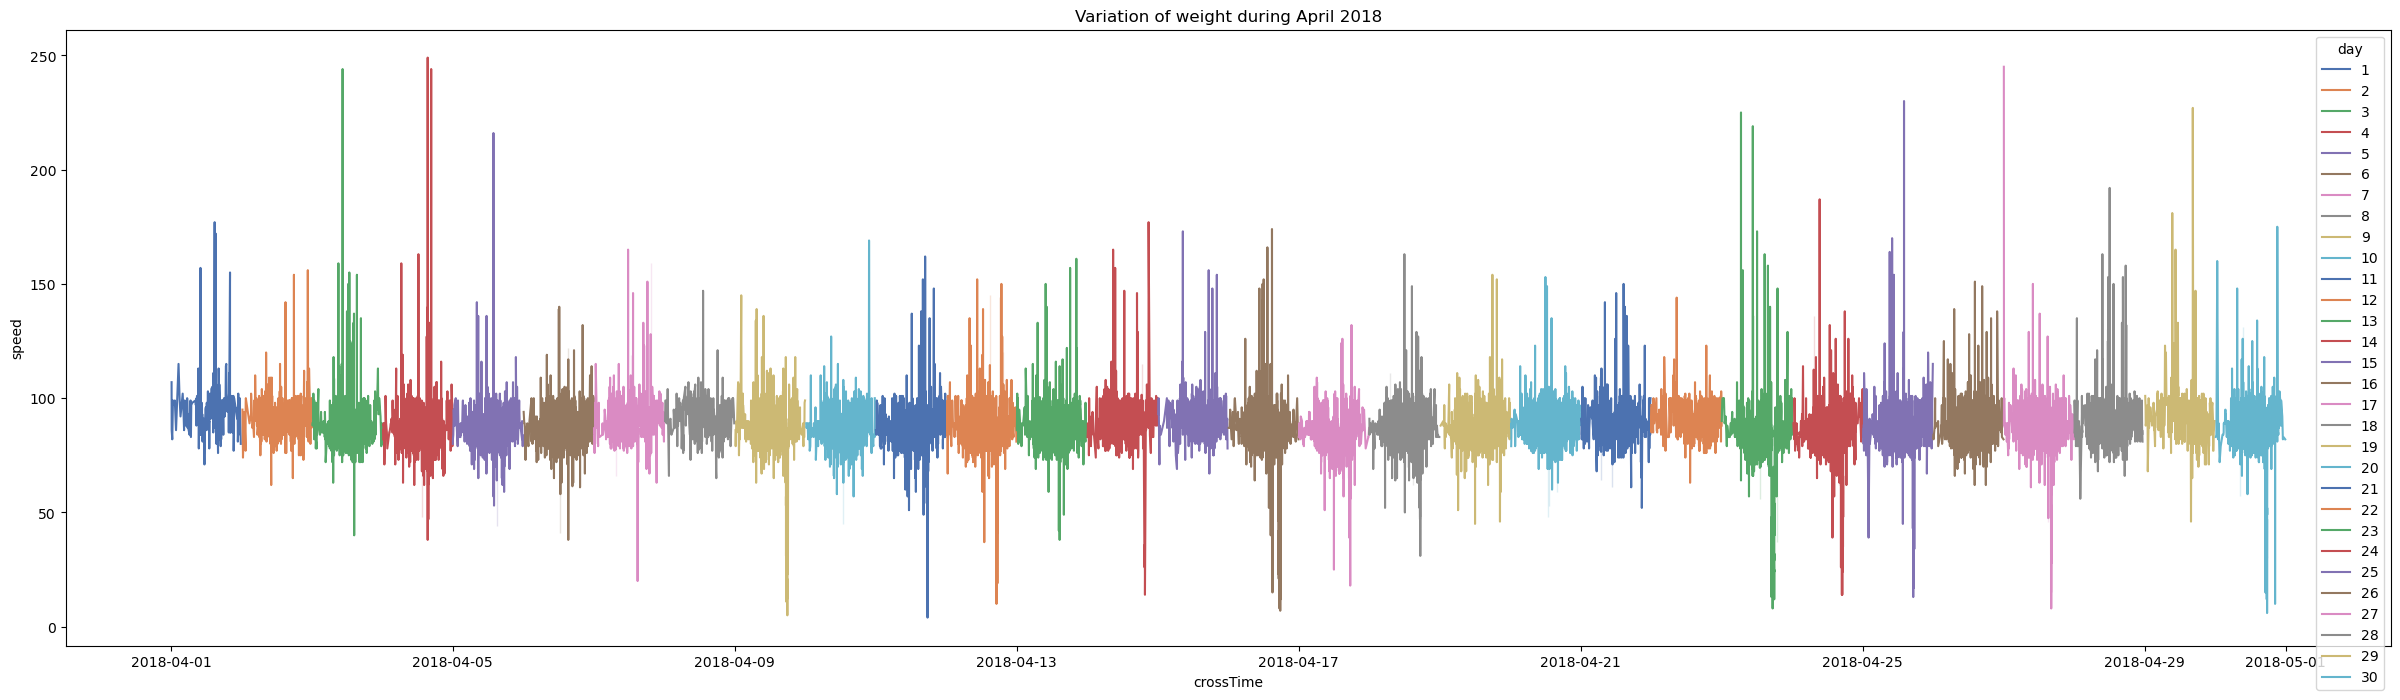

In [252]:
plt.figure(figsize=(30,8))
plt.title('Variation of speed during April 2018')
sns.lineplot(x = new_df_2018_4.crossTime, y= new_df_2018_4.speed, hue=new_df_2018_4.day, palette="deep");
plt.show()

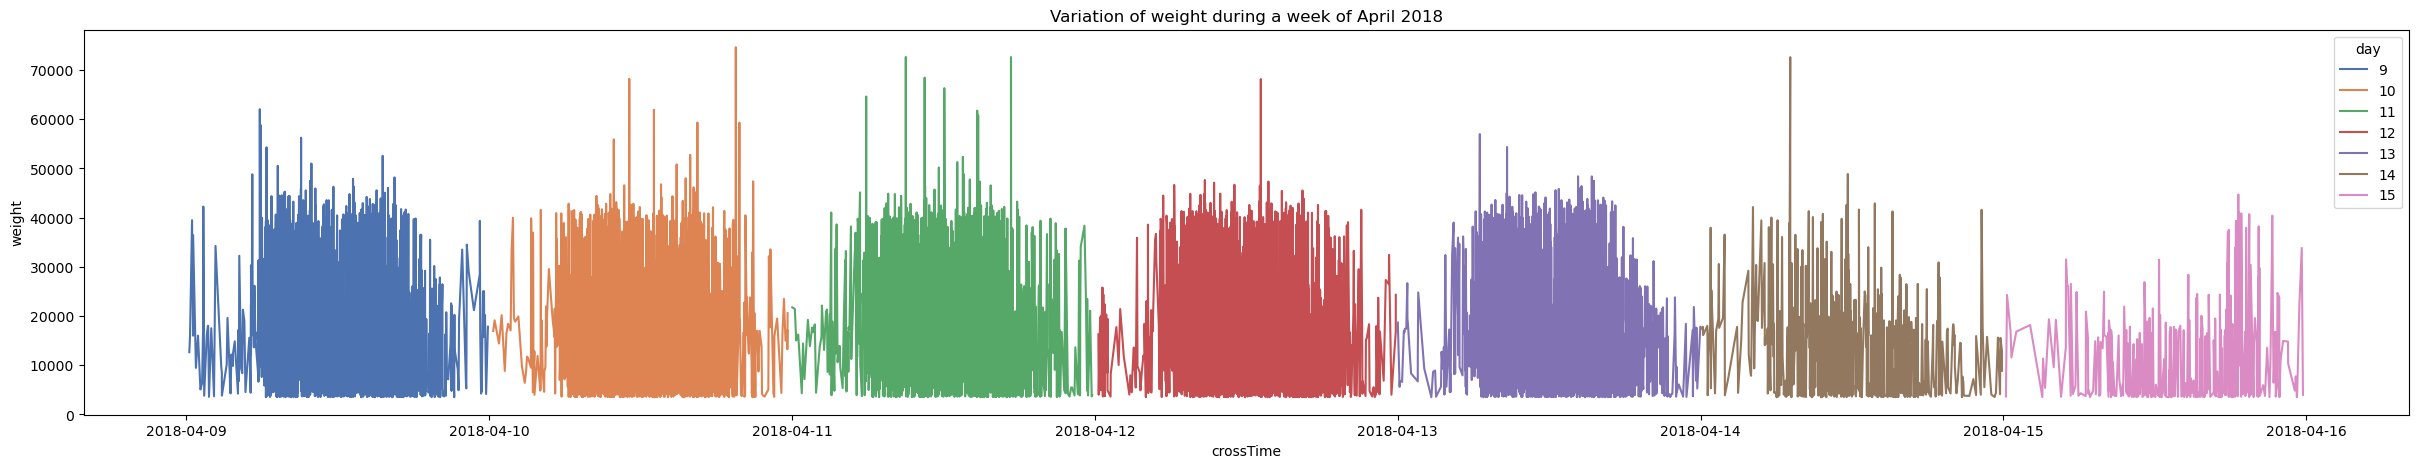

In [248]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.weight, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

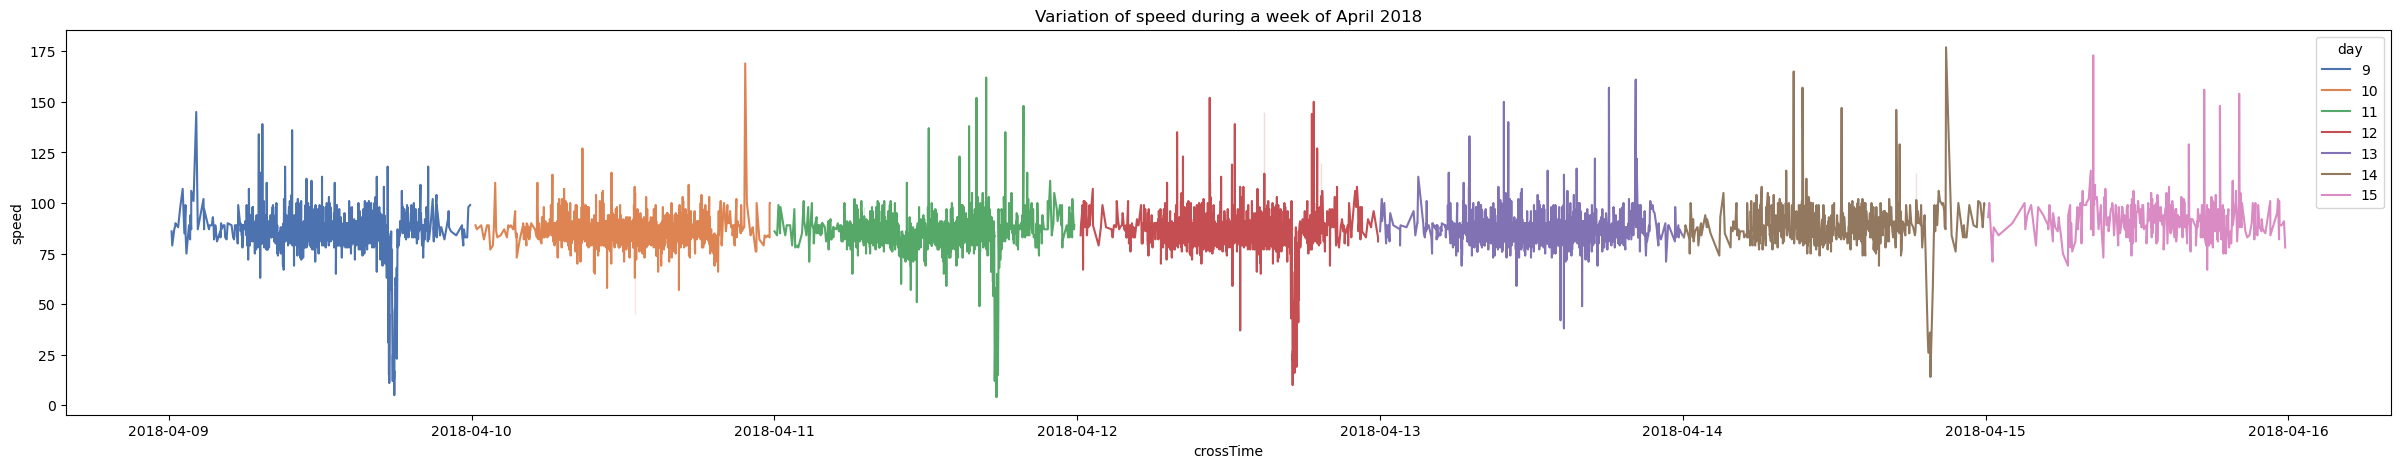

In [249]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during a week of April 2018')
sns.lineplot(x = new_df_2018_4_week.crossTime, y= new_df_2018_4_week.speed, hue=new_df_2018_4_week.day, palette="deep");
plt.show()

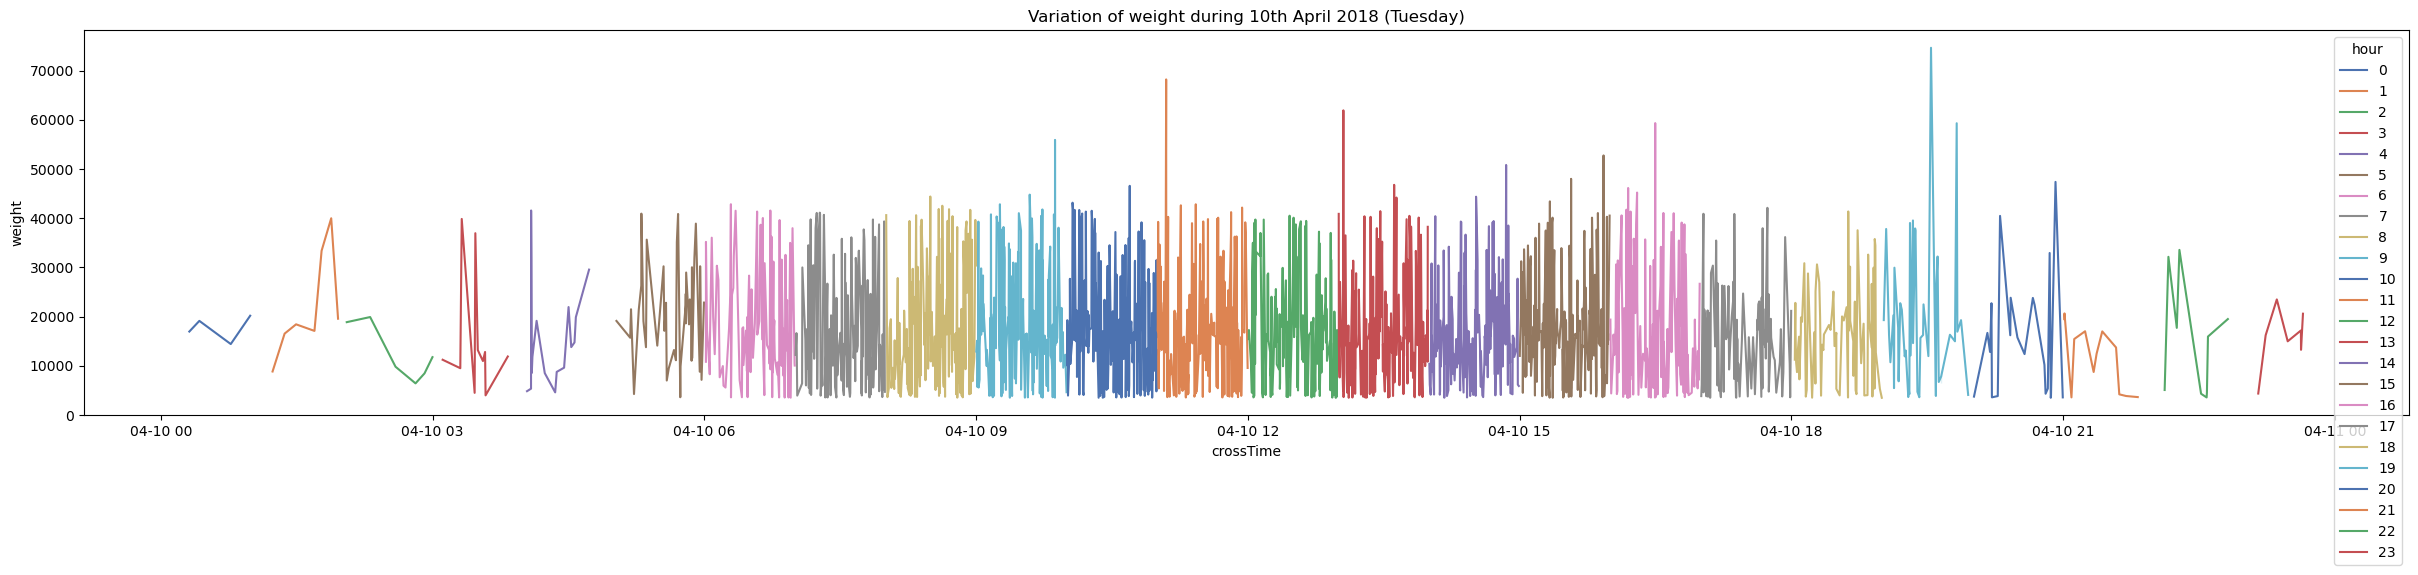

In [265]:
plt.figure(figsize=(30,5))
plt.title('Variation of weight during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.weight, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

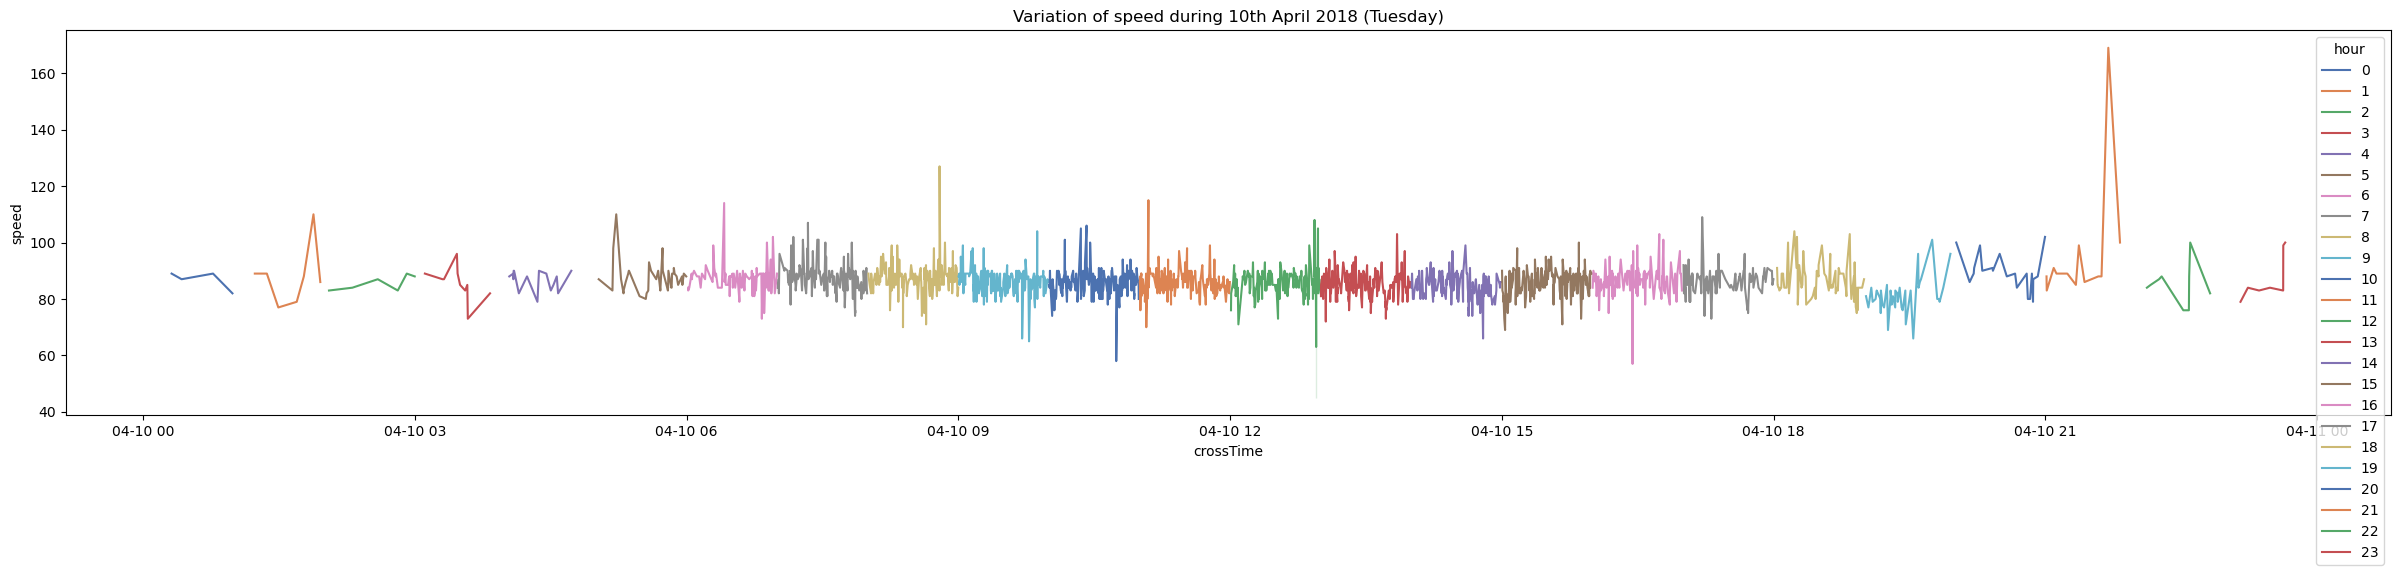

In [246]:
plt.figure(figsize=(30,5))
plt.title('Variation of speed during 10th April 2018 (Tuesday)')
sns.lineplot(x = new_df_2018_4_10.crossTime, y= new_df_2018_4_10.speed, hue=new_df_2018_4_10.hour, palette="deep");
plt.show()

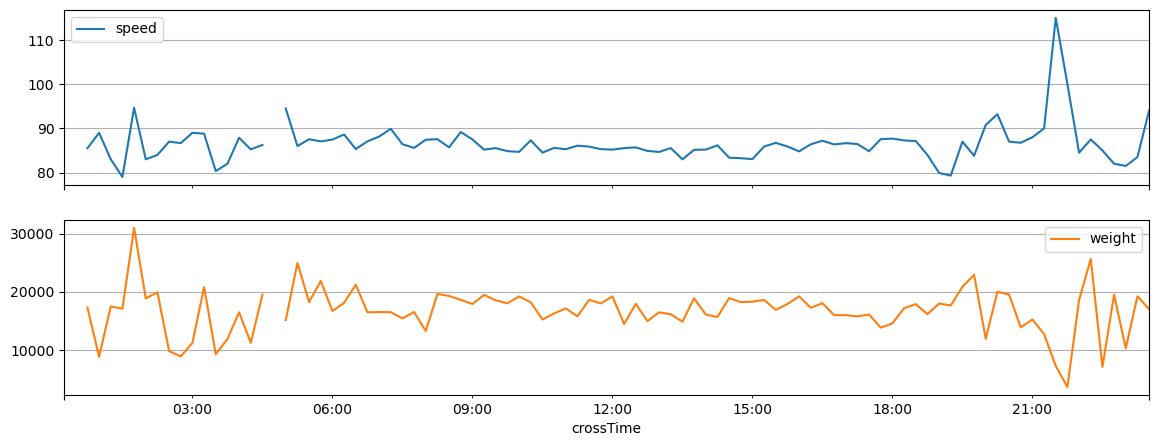

In [267]:
plot_features = new_df_2018_4_10.loc[:, ['speed', 'weight']]

plot_features.index = new_df_2018_4_10['crossTime']
plot_features.resample('15T').mean().plot(subplots=True, grid=True, figsize=(14, 5))
plt.show()

It seems like that it is quite constant from 6am to 6pm

### Speed and weight distribution

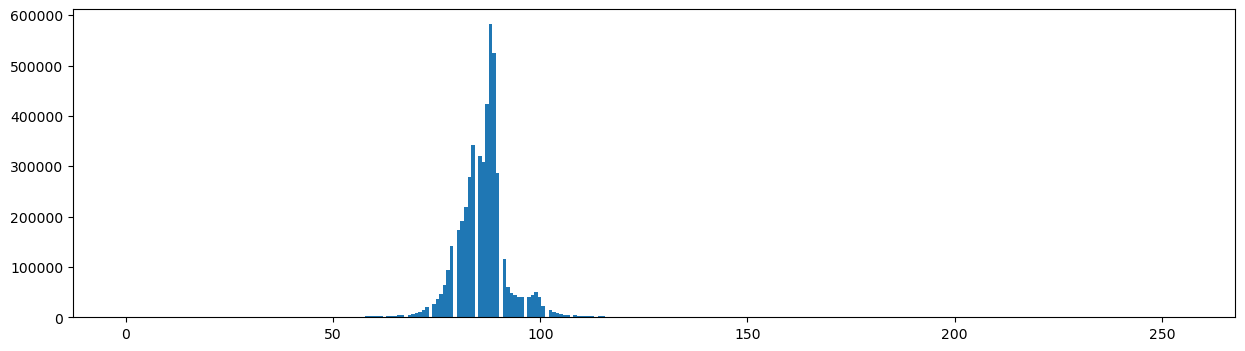

In [281]:
plt.figure(figsize=(15,4))
plt.hist(new_df.speed, bins = 300)
plt.show()

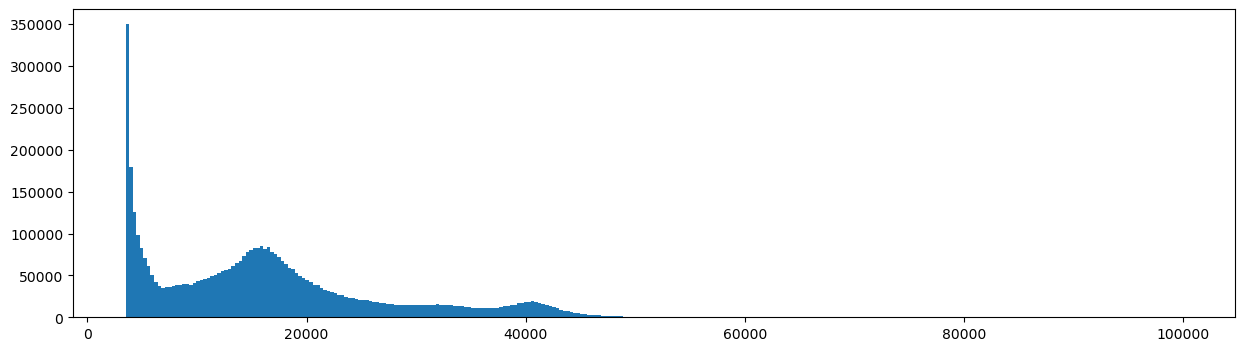

In [282]:
plt.figure(figsize=(15,4))
plt.hist(new_df.weight, bins = 300)
plt.show()

## Autocorrelation and partial autocorrelation plot

In [88]:
#TODO

### Alerte chantier

In [20]:
dist_cols = [col for col in columns if col == 'speed']
new_distr = new_df[dist_cols]
new_distr.index = new_df.crossTime

In [21]:
new_distr.resample('2min').count().max()

speed    28
dtype: int64

N for each resampling
- Resample 1h : N = 396
- Resample 30min : N = 213
- Resample 15min : N = 117
- Resample 10 min : N = 93
- Resample 5min : N = 61
- Resample 3min : N = 39
- Resample 2min : N = 28
- Resample 1min : N = 21


In [24]:
blbl = new_distr.resample('2min').agg({'speed':[list, 'mean', 'std', 'count']})
#dfrs=df.resample('6H',on='date').agg({'x':[list,'mean']})


speed                 
                      list   mean std count
crossTime                                  
2011-04-01 00:40:00  [106]  106.0 NaN     1
2011-04-01 00:42:00  [116]  116.0 NaN     1
2011-04-01 00:44:00     []    NaN NaN     0
2011-04-01 00:46:00   [84]   84.0 NaN     1
2011-04-01 00:48:00     []    NaN NaN     0
...                    ...    ...  ..   ...
2021-03-28 23:20:00   [84]   84.0 NaN     1
2021-03-28 23:22:00   [82]   82.0 NaN     1
2021-03-28 23:24:00     []    NaN NaN     0
2021-03-28 23:26:00     []    NaN NaN     0
2021-03-28 23:28:00   [99]   99.0 NaN     1

[2627965 rows x 4 columns]

In [26]:
#plt.hist(blbl.iloc[0][0])
#plt.show()
blbl['speed']['count'].unique()

array([ 1,  0,  2,  3,  7,  4,  5,  6,  8,  9, 10, 11, 12, 14, 13, 19, 23,
       17, 15, 16, 21, 22, 18, 25, 20, 24, 26, 27, 28])

In [68]:
#blbl['speed']['list'].where(len(blbl['speed']['list']) > 27)
reblbl = blbl['speed']['count'].to_frame()

In [119]:
reblbl.loc[reblbl['count'] == 27]

,count
crossTime,
2017-12-05 07:32:00,27
2019-01-25 07:56:00,27
2019-01-29 07:44:00,27


In [95]:
#reblbl.iloc['2017-12-05 07:32:00']
reblbl.index.get_loc('2017-12-05 07:32:00')

1757006

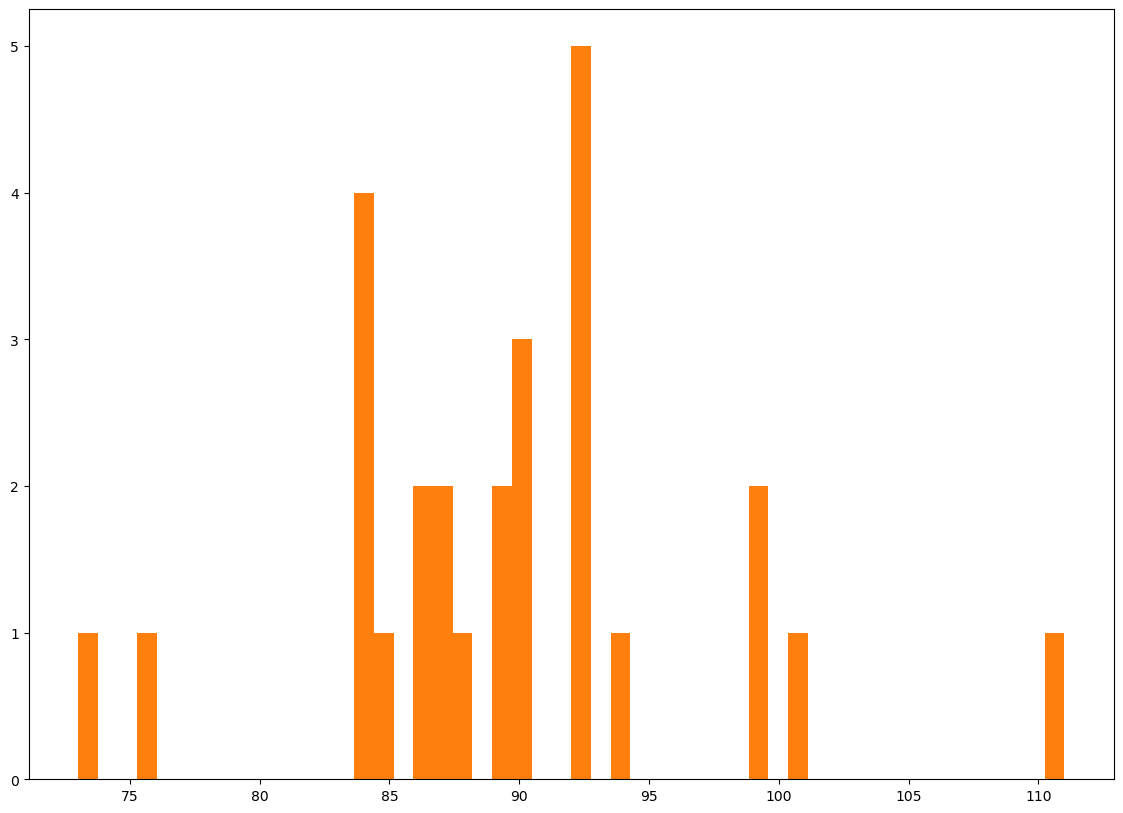

In [106]:
plt.hist(blbl['speed']['list'].iloc[1757006], bins=50)
plt.show()

In [45]:
#Trouve le timestep avec le + grand nbre de véhicules, retourne une liste
bite = max(blbl['speed']['list'], key=len)


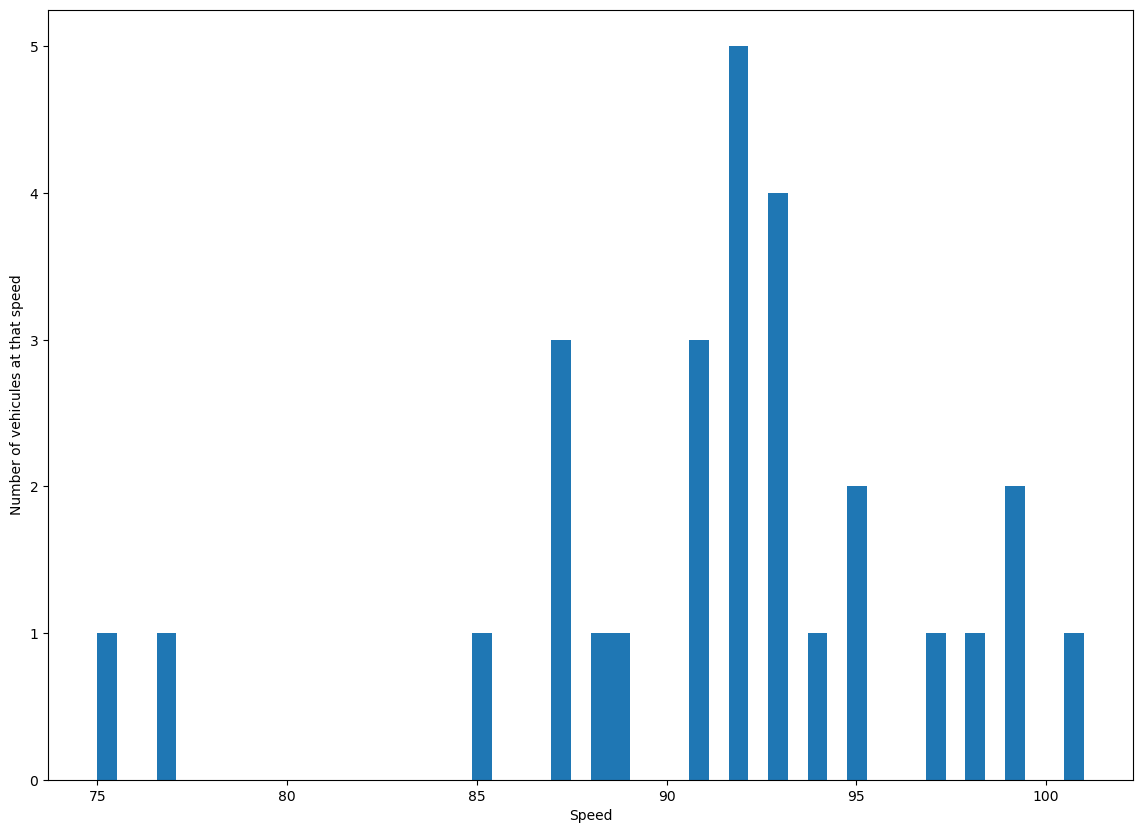

In [218]:
plt.hist(bite, bins=50)
plt.xlabel('Speed')
plt.ylabel('Number of vehicules at that speed')
plt.show()